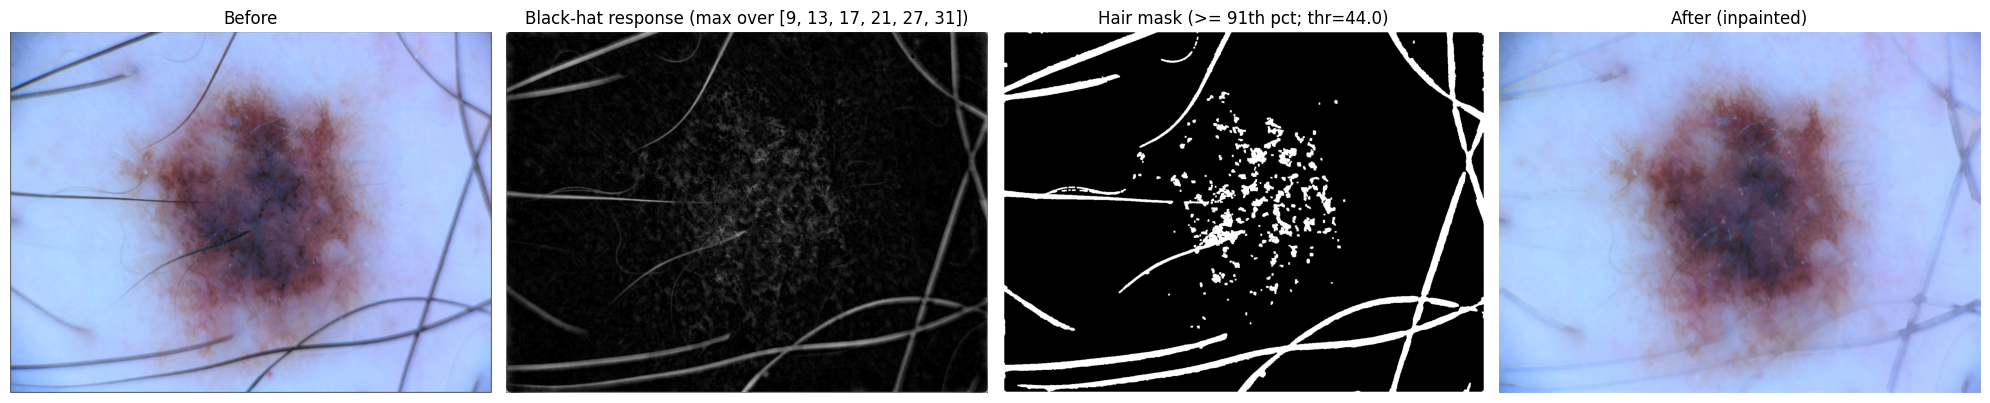

In [2]:
# - Use multi-scale black-hat (several kernel sizes) and take the max response
## explains strategy
# - Normalize the black-hat response
## normalizing for thresholding
# - Use a percentile-based threshold (more reliable when hairs occupy few pixels)
## percentile beats otsu when sparse
# - Visualize the black-hat response to debug
## plotting for sanity check

import cv2  # core OpenCV functions
import numpy as np  # array math
import matplotlib.pyplot as plt  # plotting

# --- 1) Load one dermoscopy image ---
img_path = "ISIC_0000042.jpg"  # chosen input image path

bgr = cv2.imread(img_path)  # read image as BGR
if bgr is None:  # guard against missing file
    raise FileNotFoundError(f"Could not read image at: {img_path}")

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)  # convert to RGB for display

# --- 2) Hair detection (multi-scale black-hat) ---
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)  # grayscale for morphology

# Contrast boost helps when hair is only slightly darker than skin
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))  # CLAHE instance
gray_c = clahe.apply(gray)  # apply contrast boost

# Multi-scale kernels: detect different hair thicknesses
kernel_sizes = [9, 13, 17, 21, 27, 31]  # structuring element sizes
blackhat_stack = []  # holds responses per scale
for ks in kernel_sizes:  # iterate scales
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ks, ks))  # elliptical kernel
    bh = cv2.morphologyEx(gray_c, cv2.MORPH_BLACKHAT, k)  # black-hat at this scale
    blackhat_stack.append(bh)  # collect response

blackhat = np.max(np.stack(blackhat_stack, axis=0), axis=0).astype(np.uint8)  # max over scales

# Normalize for stable thresholding across images
blackhat_n = cv2.normalize(blackhat, None, 0, 255, cv2.NORM_MINMAX)  # stretch to 0-255

# --- 3) Build hair mask (percentile threshold) ---
pct = 91  # percentile controlling strictness
thr = np.percentile(blackhat_n, pct)  # compute percentile threshold
thr = max(thr, 10)  # avoid tiny thresholds on flat images

hair_mask = (blackhat_n >= thr).astype(np.uint8) * 255  # binary mask

# Clean up: connect broken hairs, suppress speckle
hair_mask = cv2.morphologyEx(hair_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)  # close gaps
hair_mask = cv2.morphologyEx(hair_mask, cv2.MORPH_OPEN,  np.ones((3, 3), np.uint8), iterations=1)   # remove speckle noise

# Dilate slightly so inpainting covers full hair width
hair_mask = cv2.dilate(hair_mask, np.ones((3, 3), np.uint8), iterations=1)  # grow mask slightly

# remove very small components (noise)
min_area = 30  # minimum component size in pixels
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(hair_mask, connectivity=8)  # label components
clean = np.zeros_like(hair_mask)  # init clean mask
for i in range(1, num_labels):  # skip background label 0
    if stats[i, cv2.CC_STAT_AREA] >= min_area:  # keep large blobs
        clean[labels == i] = 255  # copy kept component
hair_mask = clean  # update mask

# --- 4) Remove hairs via inpainting ---
inpaint_radius = 3  # radius for Telea inpainting
bgr_inpaint = cv2.inpaint(bgr, hair_mask, inpaint_radius, cv2.INPAINT_TELEA)  # fill masked hairs

# Light smoothing (optional)
bgr_out = cv2.bilateralFilter(bgr_inpaint, d=5, sigmaColor=35, sigmaSpace=35)  # denoise while keeping edges
rgb_out = cv2.cvtColor(bgr_out, cv2.COLOR_BGR2RGB)  # to RGB for plotting

# --- 5) Visualize before / blackhat / mask / after ---
plt.figure(figsize=(20, 5))  # wide canvas

plt.subplot(1, 4, 1)  # slot 1
plt.imshow(rgb)  # original
plt.title("Before")  # title
plt.axis("off")  # hide axes

plt.subplot(1, 4, 2)  # slot 2
plt.imshow(blackhat_n, cmap="gray")  # black-hat response
plt.title(f"Black-hat response (max over {kernel_sizes})")  # title
plt.axis("off")  # hide axes

plt.subplot(1, 4, 3)  # slot 3
plt.imshow(hair_mask, cmap="gray")  # hair mask
plt.title(f"Hair mask (>= {pct}th pct; thr={thr:.1f})")  # title
plt.axis("off")  # hide axes

plt.subplot(1, 4, 4)  # slot 4
plt.imshow(rgb_out)  # inpainted result
plt.title("After (inpainted)")  # title
plt.axis("off")  # hide axes

plt.tight_layout()  # compact spacing
plt.show()  # render figure

# --- Tips ---
# If still get an empty/weak mask:
## - Lower pct (e.g., 96 or 95)
## - Increase CLAHE clipLimit slightly (e.g., 3.0)
## - Add a larger kernel size (e.g., 27)
# If you get too much false detection on lesion texture:
## - Raise pct (e.g., 98.5)
## - Increase min_area
## - Reduce CLAHE clipLimit


In [ ]:
# Step 2 — Lesion segmentation (classic CV, no learning)
# Input: hair-cleaned image from Step 1 (bgr_out OR rgb_out)
# Output: lesion_mask, contour overlay, masked lesion

import cv2  # core OpenCV functions
import numpy as np  # array math
import matplotlib.pyplot as plt  # plotting

# --- Input ---
# Option A: use bgr_out from Step 1 (preferred)
try:  # attempt to use bgr_out
    bgr_clean = bgr_out.copy()  # copy hair-cleaned BGR image
except NameError:  # if bgr_out not available
    # Option B: if you only have rgb_out from Step 1, convert it back
    try:  # attempt to use rgb_out
        bgr_clean = cv2.cvtColor(rgb_out, cv2.COLOR_RGB2BGR)  # convert RGB to BGR
    except NameError:  # if both unavailable
        raise NameError("Provide hair-cleaned image as bgr_out (BGR) or rgb_out (RGB) from Step 1.")  # error message

rgb_clean = cv2.cvtColor(bgr_clean, cv2.COLOR_BGR2RGB)  # convert BGR to RGB for display

# --- 1) Convert to Lab ---
lab = cv2.cvtColor(bgr_clean, cv2.COLOR_BGR2LAB)  # convert BGR to Lab color space
L, A, B = cv2.split(lab)  # split Lab image into L, A, B channels

# --- 2) Lesion-likelihood map (deterministic heuristic) ---
# Pigmented lesions tend to differ in chroma vs surrounding skin.
A_f = A.astype(np.float32)  # convert A channel to float32
B_f = B.astype(np.float32)  # convert B channel to float32

# Use robust skin reference (median) rather than mean
A0 = np.median(A_f)  # compute median of A channel as skin reference
B0 = np.median(B_f)  # compute median of B channel as skin reference

# Chroma distance from typical skin; smooth to suppress high-frequency texture
likelihood = np.abs(A_f - A0) + 0.8 * np.abs(B_f - B0)  # weighted chroma distance
likelihood = cv2.GaussianBlur(likelihood, (0, 0), sigmaX=2.5, sigmaY=2.5)  # blur to smooth noise

# Normalize to 8-bit for thresholding
likelihood_u8 = cv2.normalize(likelihood, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)  # scale to 0-255

# --- 3) Threshold (Otsu) ---
# (We also keep a debug view of the raw Otsu mask before any processing.)
t, otsu_mask = cv2.threshold(likelihood_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # auto-threshold
print("Otsu threshold:", t, "coverage:", otsu_mask.mean() / 255)  # print debug info

# If Otsu selects mostly background (too white), invert
if (otsu_mask.mean() / 255.0) > 0.6:  # if mask is mostly white
    otsu_mask = cv2.bitwise_not(otsu_mask)  # invert binary mask

# --- 4) Keep largest connected component immediately (removes speckles safely) ---
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(otsu_mask, connectivity=8)  # label connected regions
if num_labels <= 1:  # if no regions found
    raise RuntimeError("Thresholding produced an empty mask. Try adjusting the likelihood map smoothing.")  # error

areas = stats[1:, cv2.CC_STAT_AREA]  # extract areas of all components (skip background)
largest = 1 + int(np.argmax(areas))  # find index of largest component
lesion_mask = (labels == largest).astype(np.uint8) * 255  # extract largest component as mask

# --- 5) Fill holes (hair lines can carve holes through lesion) ---
# Flood-fill the background, invert, OR back in to fill internal holes
h, w = lesion_mask.shape  # get mask dimensions
ff = lesion_mask.copy()  # copy mask for flood fill
mask_ff = np.zeros((h + 2, w + 2), np.uint8)  # init auxiliary mask (larger for flood fill)
cv2.floodFill(ff, mask_ff, seedPoint=(0, 0), newVal=255)  # flood fill from corners
holes = cv2.bitwise_not(ff)  # invert to get holes inside lesion
lesion_mask = cv2.bitwise_or(lesion_mask, holes)  # OR to fill holes back into mask

# --- 6) Boundary cleanup: CLOSE (fill gaps) + optional light OPEN (denoise) ---
# CLOSE is safer than OPEN for your images.
close_kernel = 15  # kernel size for closing operation
lesion_mask = cv2.morphologyEx(  # apply morphological closing
    lesion_mask,  # input mask
    cv2.MORPH_CLOSE,  # operation type (close gaps)
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_kernel, close_kernel)),  # elliptical kernel
    iterations=1,  # number of iterations
)

# Optional: very light open to remove tiny edge burrs (keep it small)
lesion_mask = cv2.morphologyEx(  # apply morphological opening
    lesion_mask,  # input mask
    cv2.MORPH_OPEN,  # operation type (remove small noise)
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),  # small elliptical kernel
    iterations=1,  # single iteration
)

# Optional: smooth boundary
lesion_mask = cv2.GaussianBlur(lesion_mask, (5, 5), 0)  # blur mask edges
_, lesion_mask = cv2.threshold(lesion_mask, 127, 255, cv2.THRESH_BINARY)  # re-binarize

print("Final mask coverage:", lesion_mask.mean() / 255)  # print coverage percentage

# --- 7) Contours + overlays ---
contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # extract contours

overlay = bgr_clean.copy()  # copy original image for drawing
if contours:  # if contours found
    c = max(contours, key=cv2.contourArea)  # find largest contour
    cv2.drawContours(overlay, [c], -1, (0, 255, 0), 2)  # draw contour in green

masked = cv2.bitwise_and(bgr_clean, bgr_clean, mask=lesion_mask)  # apply mask to extract lesion

rgb_overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)  # convert overlay to RGB
rgb_masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)  # convert masked image to RGB

# --- 8) Visualize ---
plt.figure(figsize=(22, 5))  # create wide figure

plt.subplot(1, 5, 1)  # subplot 1
plt.imshow(rgb_clean)  # show hair-cleaned input
plt.title("Hair-cleaned input")  # title
plt.axis("off")  # hide axes

plt.subplot(1, 5, 2)  # subplot 2
plt.imshow(likelihood_u8, cmap="gray")  # show likelihood map
plt.title("Lesion-likelihood map")  # title
plt.axis("off")  # hide axes

plt.subplot(1, 5, 3)  # subplot 3
plt.imshow(otsu_mask, cmap="gray")  # show Otsu mask
plt.title("Mask right after Otsu")  # title
plt.axis("off")  # hide axes

plt.subplot(1, 5, 4)  # subplot 4
plt.imshow(lesion_mask, cmap="gray")  # show final mask
plt.title("Final lesion mask")  # title
plt.axis("off")  # hide axes

plt.subplot(1, 5, 5)  # subplot 5
plt.imshow(rgb_overlay)  # show contour overlay
plt.title("Contour overlay")  # title
plt.axis("off")  # hide axes

plt.tight_layout()  # compact spacing
plt.show()  # render figure

plt.figure(figsize=(6, 6))  # new square figure
plt.imshow(rgb_masked)  # show masked lesion
plt.title("Masked lesion")  # title
plt.axis("off")  # hide axes
plt.show()  # render figure

# Outputs for next steps:
# - lesion_mask (uint8 0/255)
# - contours
# - masked (BGR)


Otsu threshold: 86.0 coverage: 0.21051686203192432
Final mask coverage: 0.22689185496485312
